In [144]:
import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
plt.style.use("bmh")
plt.rcParams['font.family'] = 'DejaVu Sans'

import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm

from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as spl
import statsmodels.graphics.gofplots as gpl

# Загрузка данных

In [154]:
moex = pd.read_csv('../Our_super_project/risk_factors/IMOEX.ME.csv')
oil = pd.read_csv('../Our_super_project/risk_factors/BZ=F.csv')
rts = pd.read_csv('../Our_super_project/risk_factors/RTS.csv')
zero_bonds = pd.read_csv('../Our_super_project/risk_factors/zero_bonds.csv')

In [155]:
zero_bonds.head()

,Date,0.25,0.5,0.75,1,2,3,5,7,10,15,20,30
0,2020-12-30,3.68,3.87,4.05,4.18,4.57,4.91,5.47,5.87,6.27,6.62,6.80,6.96
1,2020-12-29,3.90,4.00,4.11,4.21,4.60,4.94,5.46,5.84,6.24,6.65,6.87,7.07
2,2020-12-28,4.11,4.18,4.25,4.33,4.65,4.97,5.49,5.86,6.26,6.63,6.82,7.00
3,2020-12-25,4.16,4.23,4.30,4.37,4.68,5.00,5.51,5.88,6.26,6.61,6.79,6.96
4,2020-12-24,4.20,4.26,4.32,4.39,4.70,5.03,5.54,5.89,6.27,6.65,6.85,7.06


In [156]:
moex.Date = pd.to_datetime(moex.Date)
oil.Date = pd.to_datetime(oil.Date)
rts.Date = pd.to_datetime(rts['Дата'].rename({'Дата': 'Date'}))
zero_bonds.Date = pd.to_datetime(zero_bonds.Date)

risk_factors = moex[['Date', 'Adj Close']]\
    .merge(oil[['Date', 'Adj Close']], on='Date', how='inner')\
    .merge(rts[['Date', 'Adj Close']], on='Date', how='inner')\
    .merge(zero_bonds, on='Date', how='inner')

In [157]:
print(risk_factors.shape)
risk_factors.set_index('Date', inplace=True)
risk_factors.columns = ['moex', 'oil', 'rts'] + [f'zero_bond_{col}' for col in zero_bonds.columns[1:]]
risk_factors.head()

(833, 16)


,moex,oil,rts,zero_bond_0.25,zero_bond_0.5,zero_bond_0.75,zero_bond_1,zero_bond_2,zero_bond_3,zero_bond_5,zero_bond_7,zero_bond_10,zero_bond_15,zero_bond_20,zero_bond_30
Date,,,,,,,,,,,,,,,
2017-01-03,2285.429932,55.470001,1109.39,8.46,8.45,8.43,8.40,8.25,8.21,8.22,8.28,8.42,8.66,8.85,9.09
2017-01-06,2213.929932,57.099998,1045.63,8.34,8.36,8.36,8.35,8.24,8.17,8.15,8.21,8.35,8.60,8.80,9.06
2017-01-09,2211.250000,54.939999,1100.58,8.67,8.62,8.56,8.49,8.23,8.16,8.11,8.12,8.21,8.43,8.63,8.90
2017-01-11,2218.610107,55.099998,1126.43,8.61,8.54,8.47,8.40,8.20,8.10,8.05,8.08,8.20,8.43,8.62,8.87
2017-01-12,2212.000000,56.009998,1133.33,8.64,8.55,8.46,8.38,8.13,8.00,7.90,7.94,8.08,8.34,8.54,8.77


### Анализ риск-факторов

In [158]:
def plot_cor_matrix(risk_factors: pd.DataFrame) -> None:
    corr_matrix = risk_factors.corr()
    
    fig = plt.figure(figsize=(10, 10))
    ax = plt.subplot()
    
    sns.heatmap(corr_matrix, annot=True)
    
    plt.show()

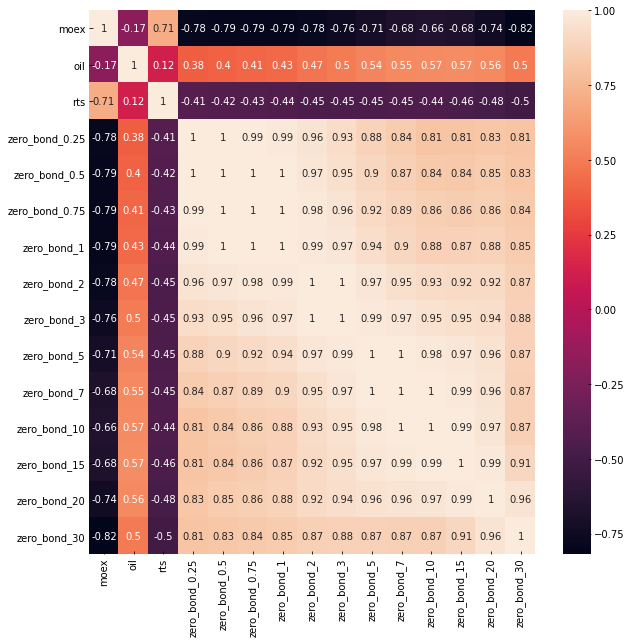

In [159]:
plot_cor_matrix(risk_factors)

In [164]:
def risk_factor_describe(risk_factor: pd.Series) -> None:
    risk_factor_name = risk_factor.name
    print(f"{'=' * 10} {risk_factor_name.upper()} {'=' * 10}")
    print(f"mean: {np.round(np.mean(risk_factor), 2)}")
    print(f"std: {np.round(np.std(risk_factor), 2)}")
    print(f"min: {np.round(np.min(risk_factor), 2)}")
    print(f"max: {np.round(np.max(risk_factor), 2)}")
    adfuller_pv = adfuller(risk_factor)[1]
    print(
        f"The Augmented Dickey-Fuller test, p-value: {adfuller_pv}, "
        f"series is {'non ' if adfuller_pv >= 0.05 else ''}stationary"
    )
    risk_factor_change = risk_factor.pct_change().iloc[1:]
    adfuller_pv = adfuller(risk_factor_change)[1]
    print(
        f"The Augmented Dickey-Fuller test for pct change, p-value: {adfuller_pv}, "
        f"series is {'non ' if adfuller_pv >= 0.05 else ''}stationary"
    )
    
    fig = plt.figure(figsize=(15, 15))
    
    ax = plt.subplot(511)
    sns.lineplot(x=risk_factor.index, y=risk_factor, ax=ax)
    plt.title('Price')
    
    ax = plt.subplot(512)
    sns.lineplot(x=risk_factor_change.index, y=risk_factor_change, ax=ax)
    plt.title('Price percent change')
    
    ax = plt.subplot(525)
    spl.plot_acf(risk_factor_change, lags=20, ax=ax)
    
    ax = plt.subplot(526)
    spl.plot_pacf(risk_factor_change, lags=20, ax=ax)
    
    ax = plt.subplot(527)
    normal_dist = gpl.ProbPlot(risk_factor_change, fit=True)
    normal_dist.qqplot(line='r', ax=ax)
    plt.title('Q-Q')
    
    ax = plt.subplot(528)
    normal_dist.ppplot(line='45', ax=ax)
    plt.title('P-P')
    
    ax = plt.subplot(529)
    normal_dist.probplot(line='r', ax=ax)
    plt.title('Prob')
    
    ax = plt.subplot(5, 2, 10)
    sns.distplot(risk_factor_change, ax=ax)
    plt.title('Distribution')
    
    plt.tight_layout()
    plt.show()

========== MOEX ==========
mean: 2481.47
std: 359.09
min: 1817.82
max: 3289.02
The Augmented Dickey-Fuller test, p-value: 0.8501399551906064, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 1.6892121579474374e-21, series is stationary


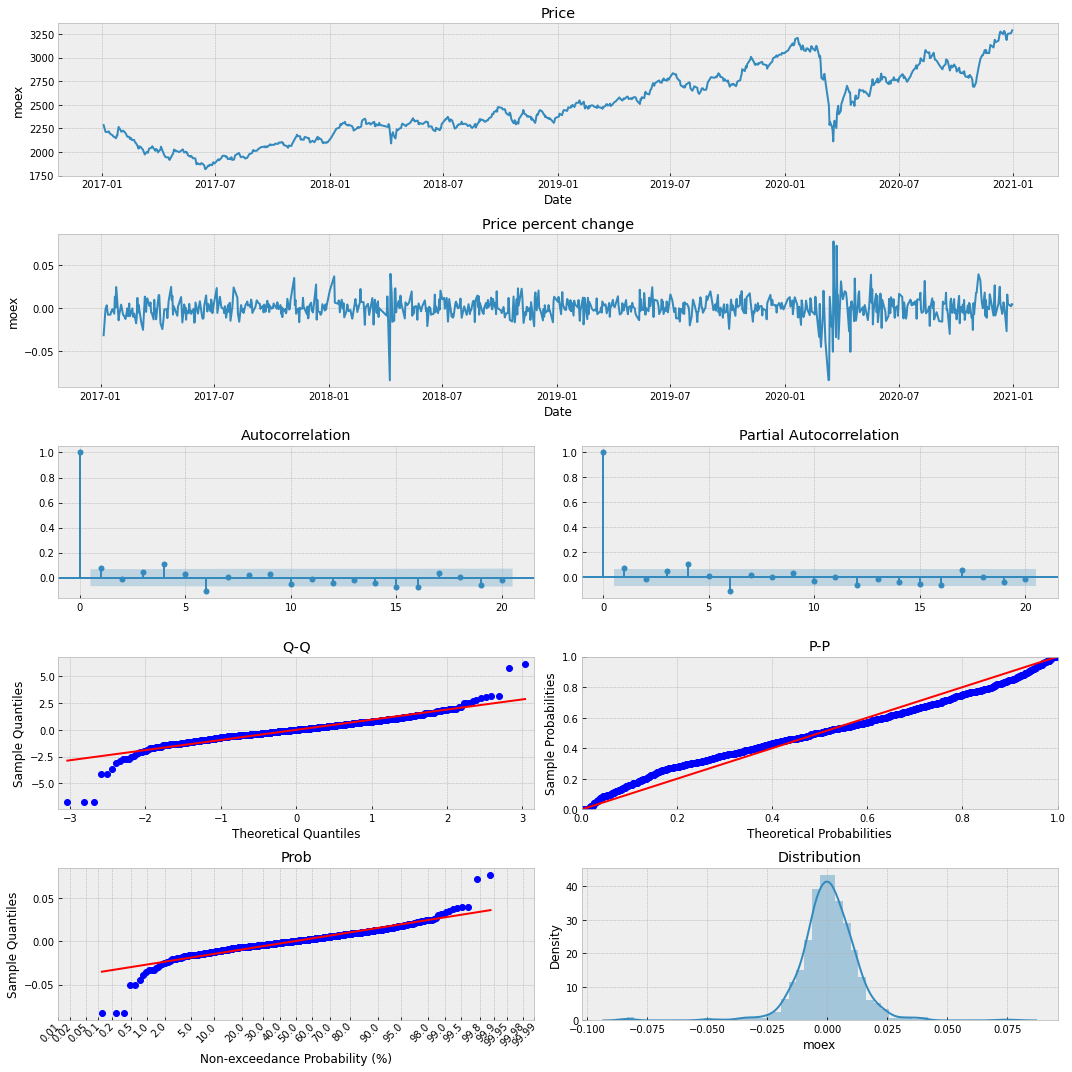

========== OIL ==========
mean: 58.3
std: 12.94
min: 19.33
max: 85.0
The Augmented Dickey-Fuller test, p-value: 0.522956536767029, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 5.04097100261234e-07, series is stationary


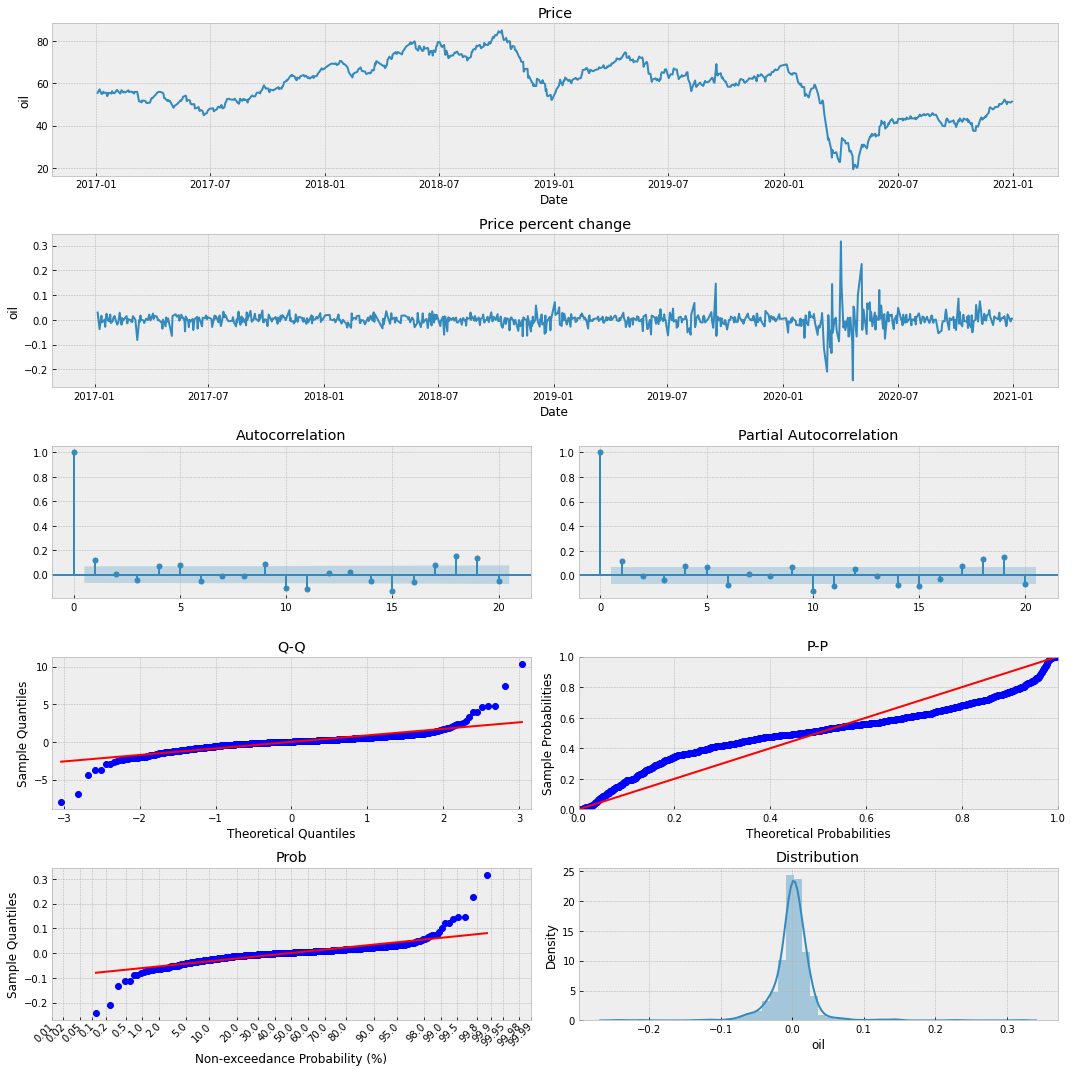

========== RTS ==========
mean: 1206.84
std: 133.8
min: 832.26
max: 1637.75
The Augmented Dickey-Fuller test, p-value: 0.33794986237551916, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 1.2044053155230607e-20, series is stationary


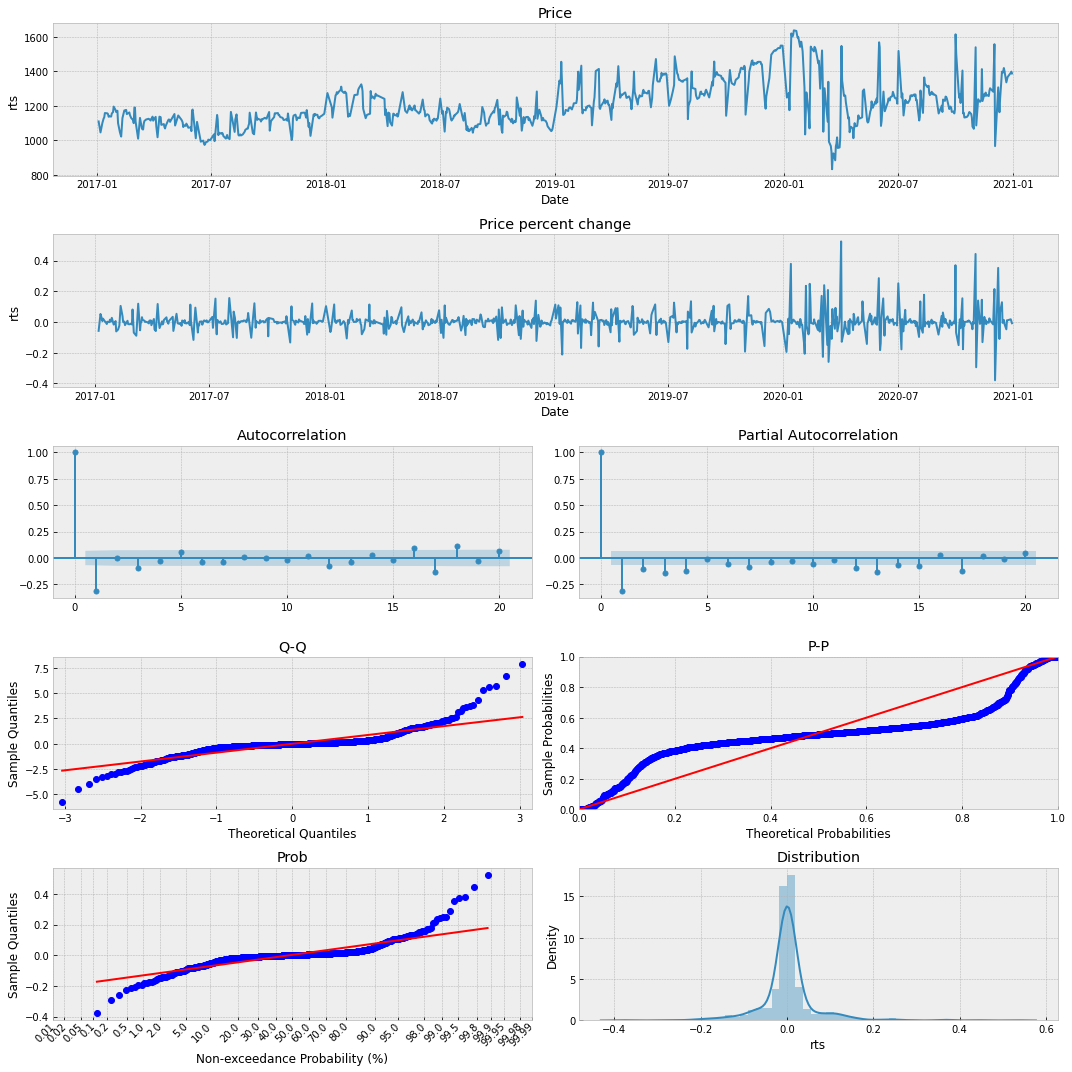

========== ZERO_BOND_0.25 ==========
mean: 6.6
std: 1.48
min: 3.68
max: 9.82
The Augmented Dickey-Fuller test, p-value: 0.90809339559853, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 2.9227246146633796e-14, series is stationary


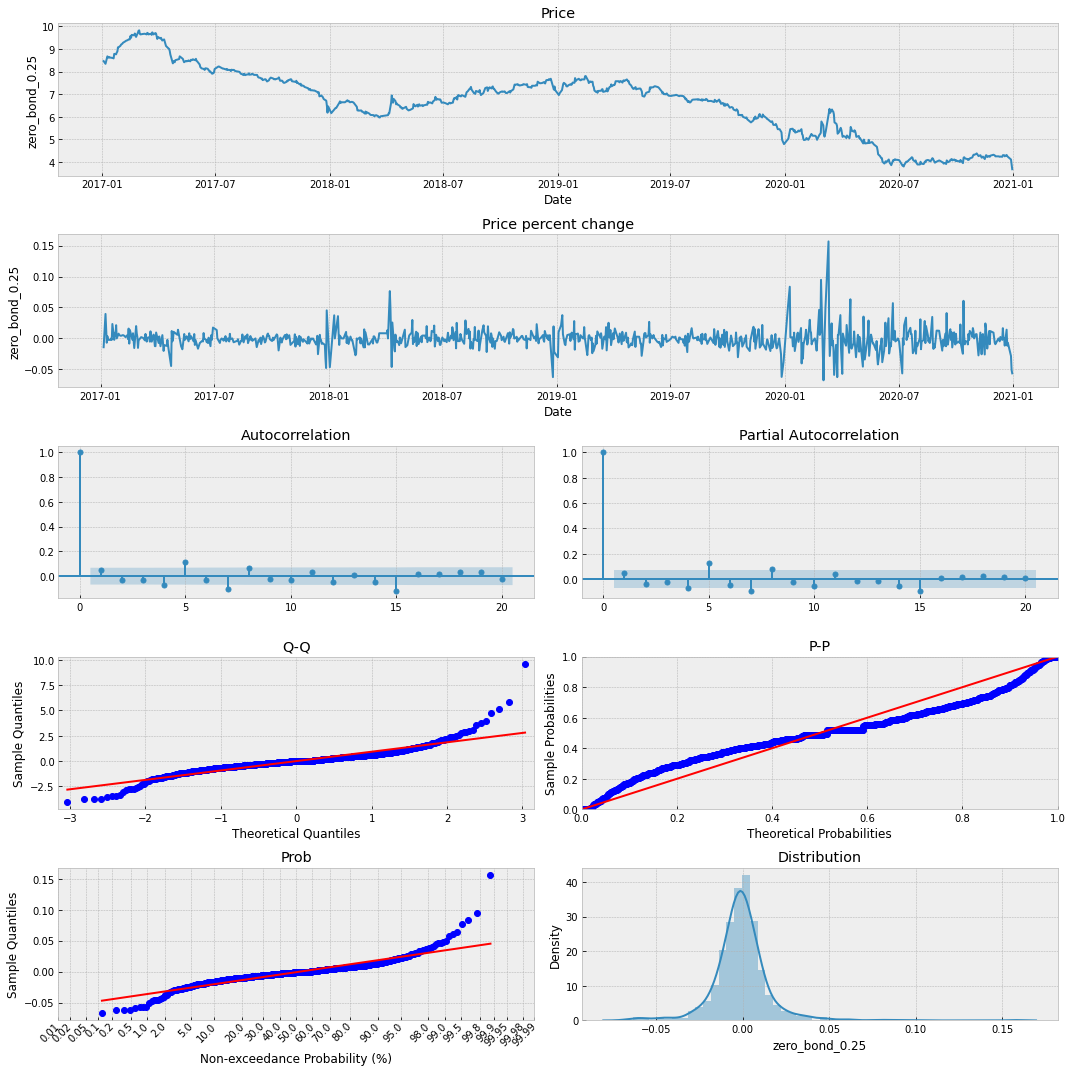

========== ZERO_BOND_0.5 ==========
mean: 6.62
std: 1.43
min: 3.87
max: 9.51
The Augmented Dickey-Fuller test, p-value: 0.9120529212750903, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 7.966783673233165e-17, series is stationary


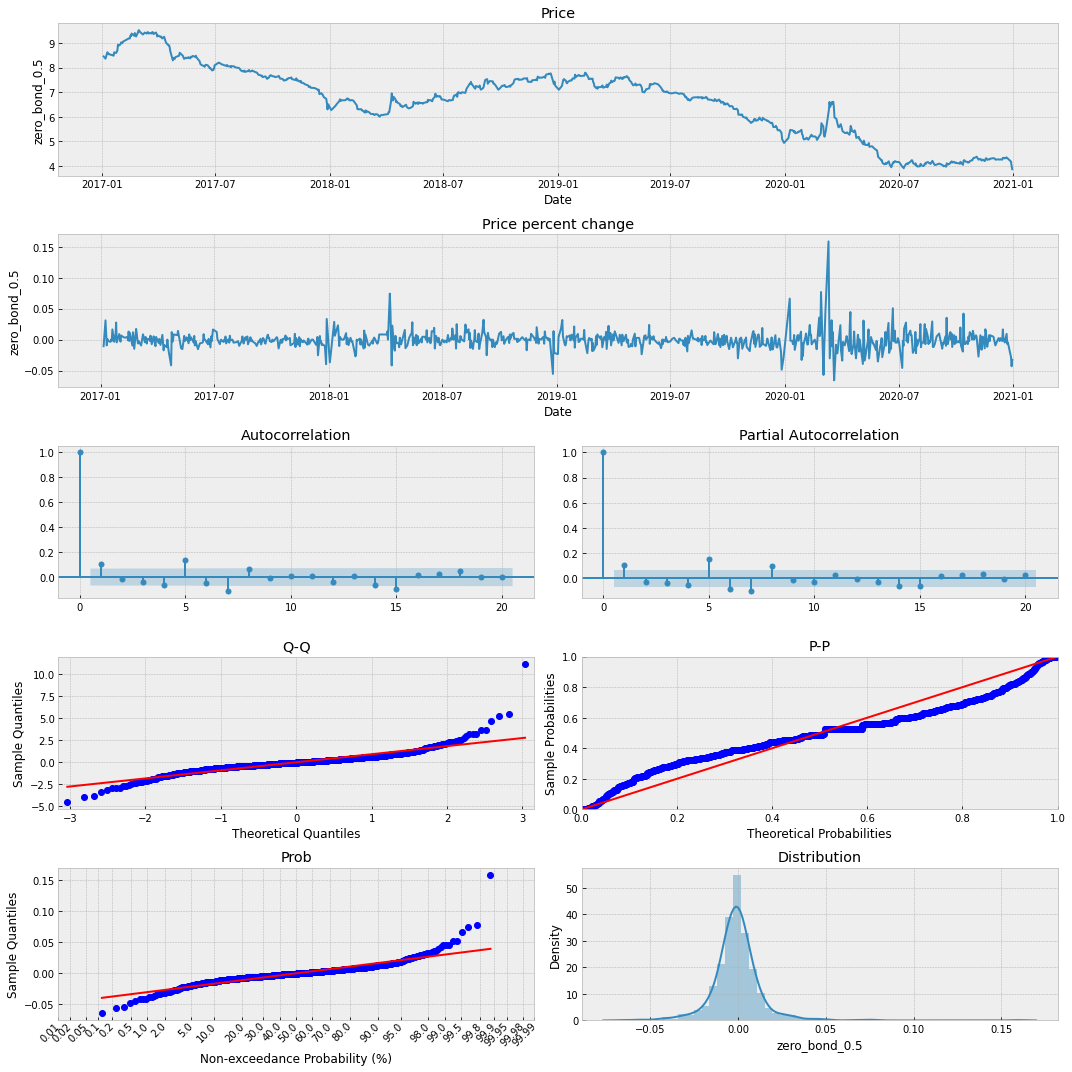

========== ZERO_BOND_0.75 ==========
mean: 6.65
std: 1.39
min: 4.02
max: 9.27
The Augmented Dickey-Fuller test, p-value: 0.9081857076942554, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 6.982766528217119e-17, series is stationary


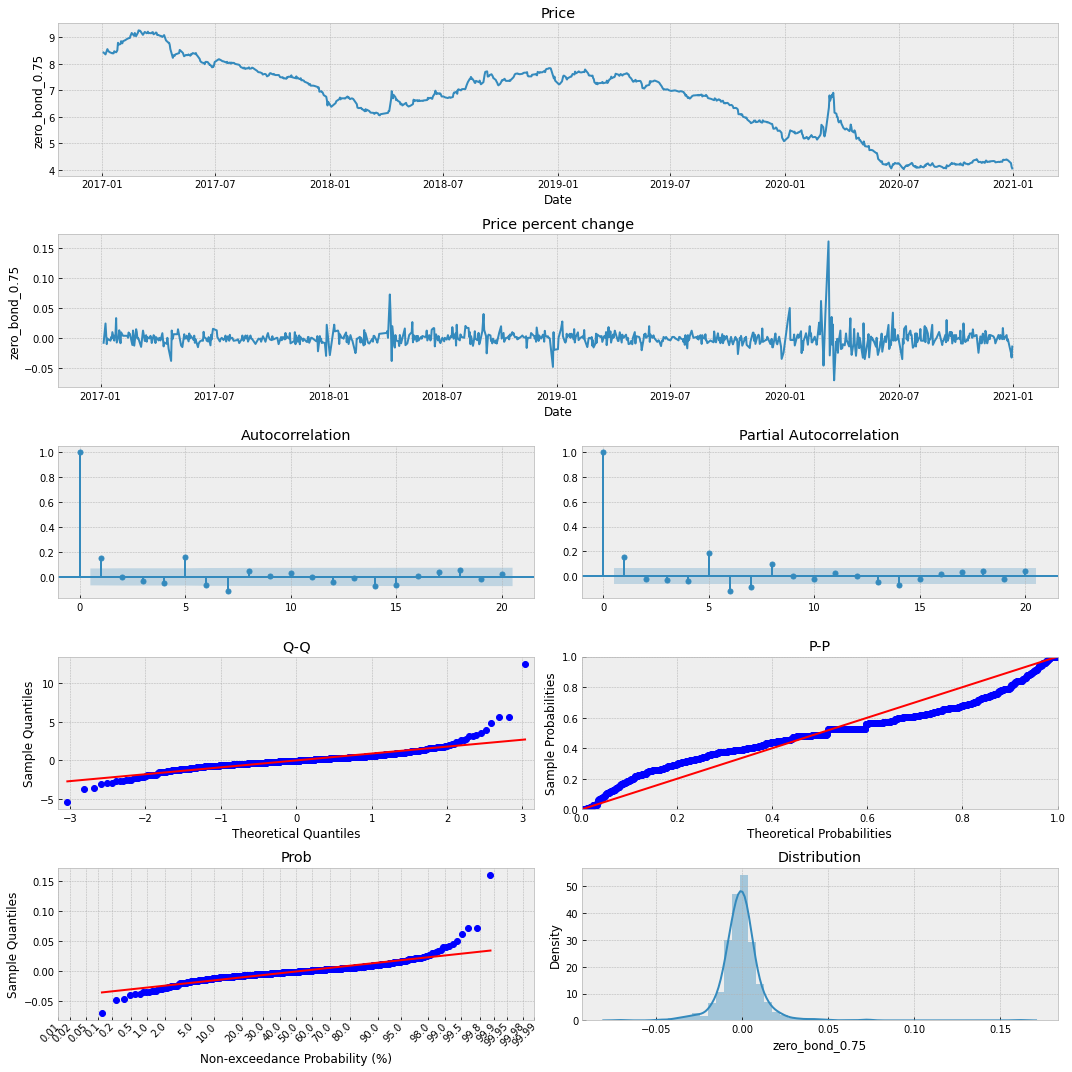

========== ZERO_BOND_1 ==========
mean: 6.68
std: 1.36
min: 4.12
max: 9.1
The Augmented Dickey-Fuller test, p-value: 0.9047332994462477, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 1.4003674532306243e-16, series is stationary


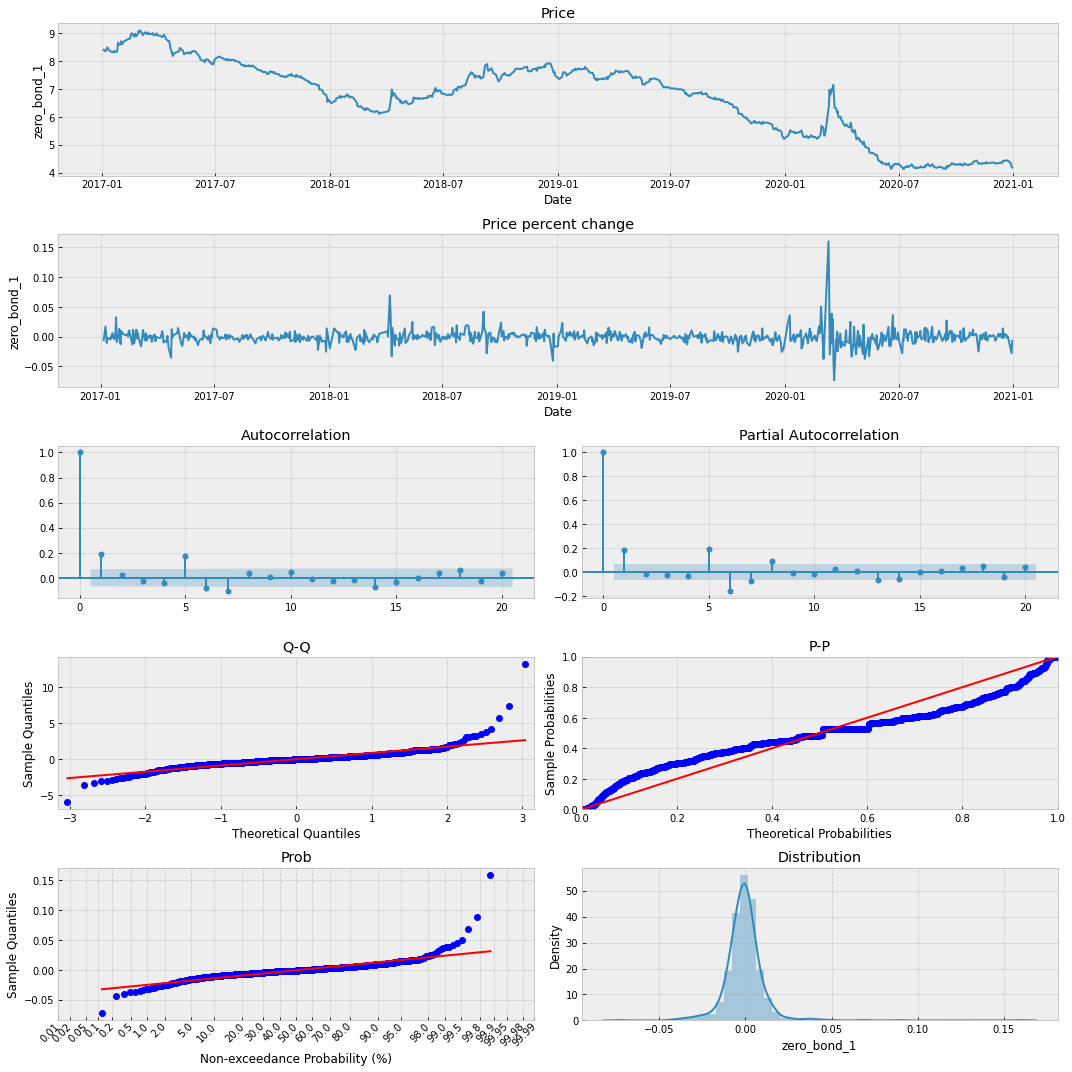

========== ZERO_BOND_2 ==========
mean: 6.79
std: 1.27
min: 4.38
max: 8.68
The Augmented Dickey-Fuller test, p-value: 0.894881424879608, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 2.3966418384599414e-21, series is stationary


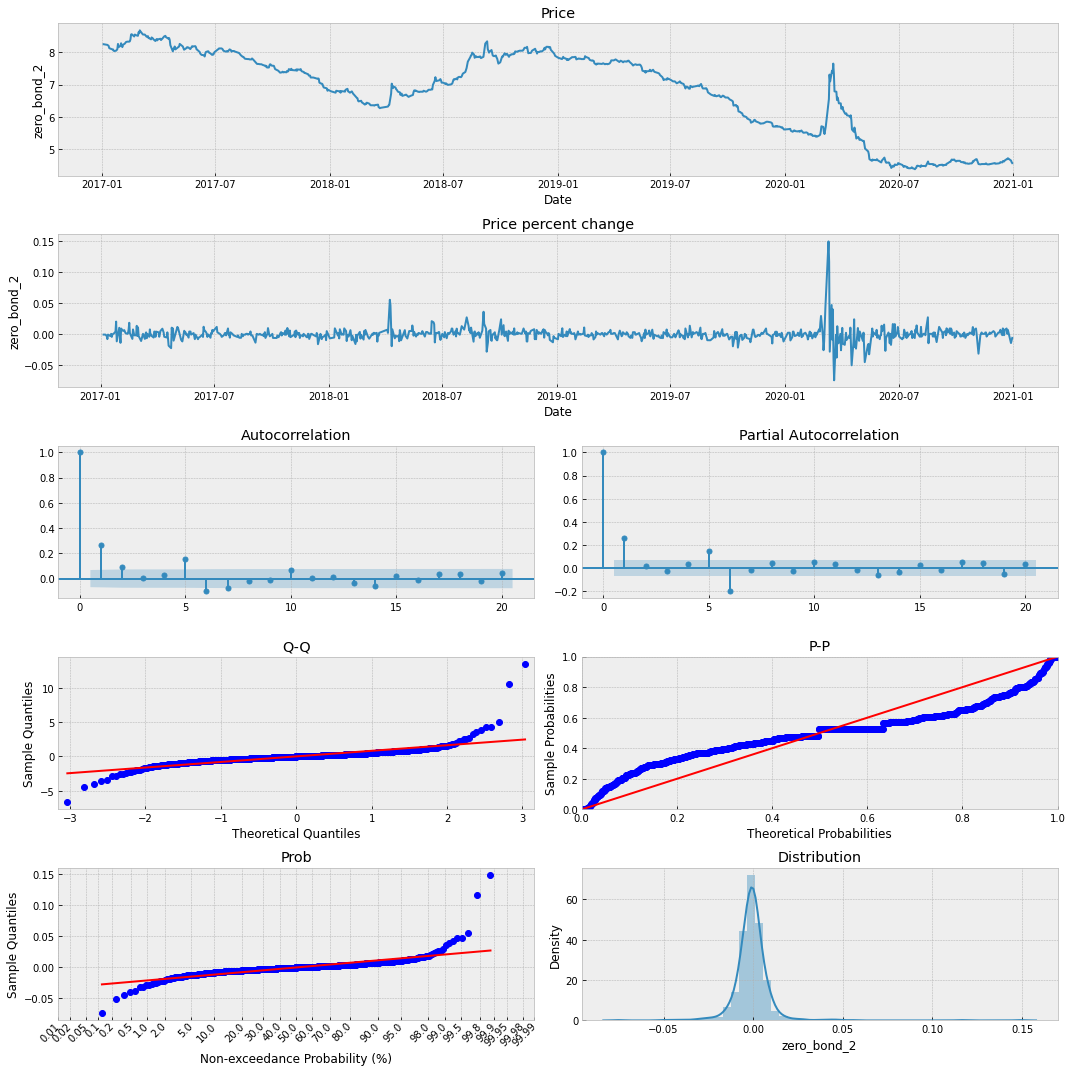

========== ZERO_BOND_3 ==========
mean: 6.9
std: 1.2
min: 4.6
max: 8.65
The Augmented Dickey-Fuller test, p-value: 0.853819740037342, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 5.3948325813476914e-21, series is stationary


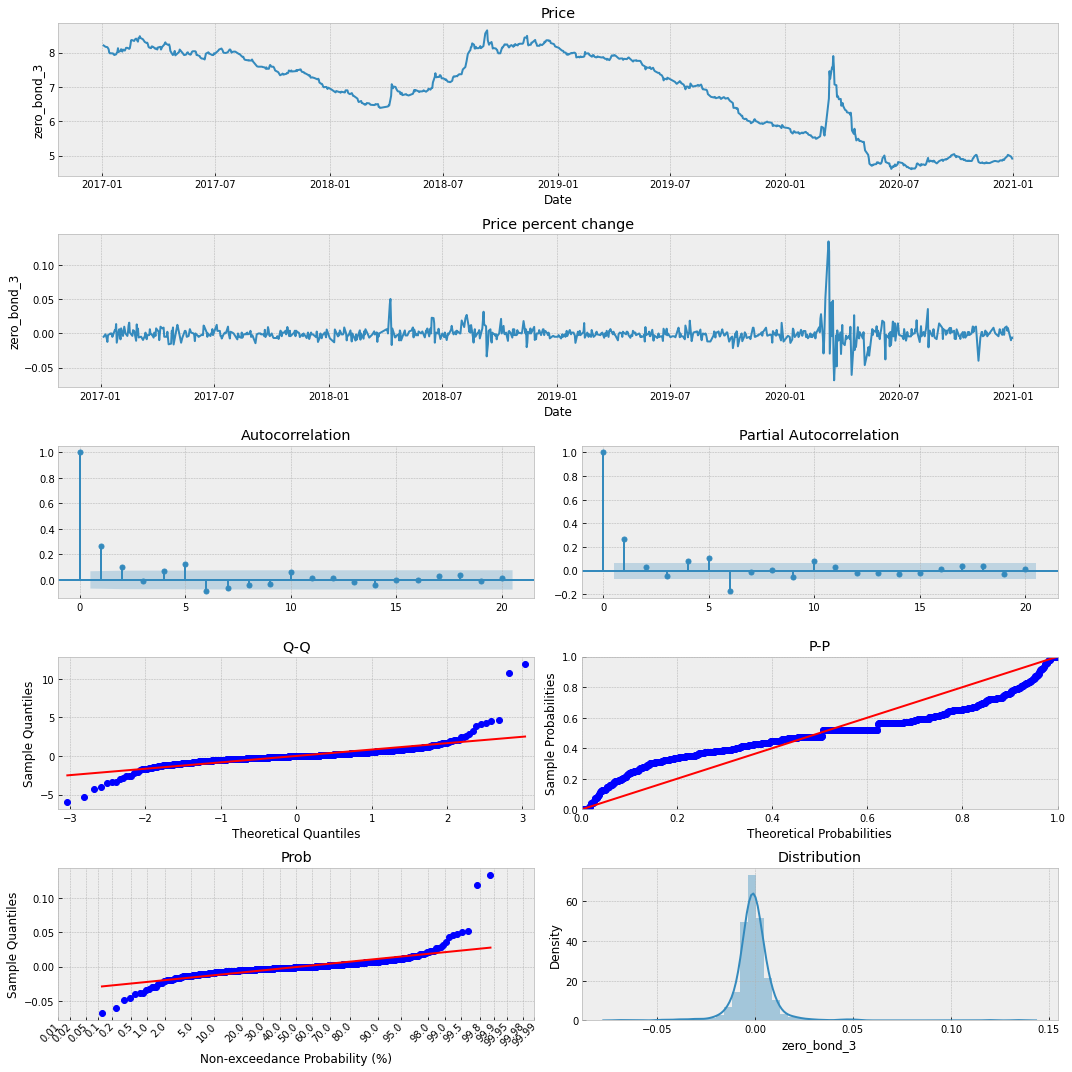

========== ZERO_BOND_5 ==========
mean: 7.09
std: 1.08
min: 4.95
max: 9.02
The Augmented Dickey-Fuller test, p-value: 0.7434881371349759, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 1.499729571453493e-20, series is stationary


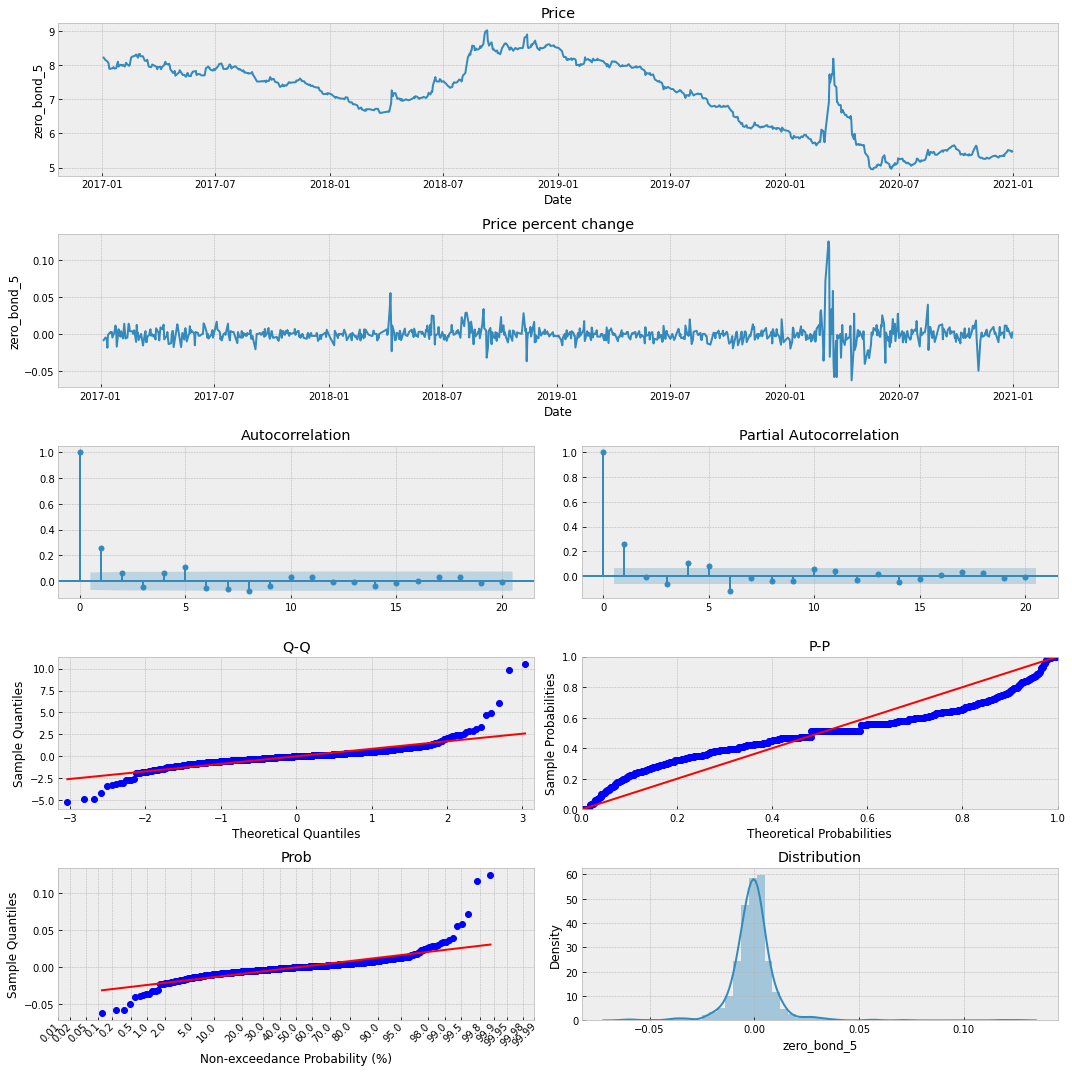

========== ZERO_BOND_7 ==========
mean: 7.24
std: 0.99
min: 5.22
max: 9.19
The Augmented Dickey-Fuller test, p-value: 0.6560734514293026, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 1.3792813556577575e-20, series is stationary


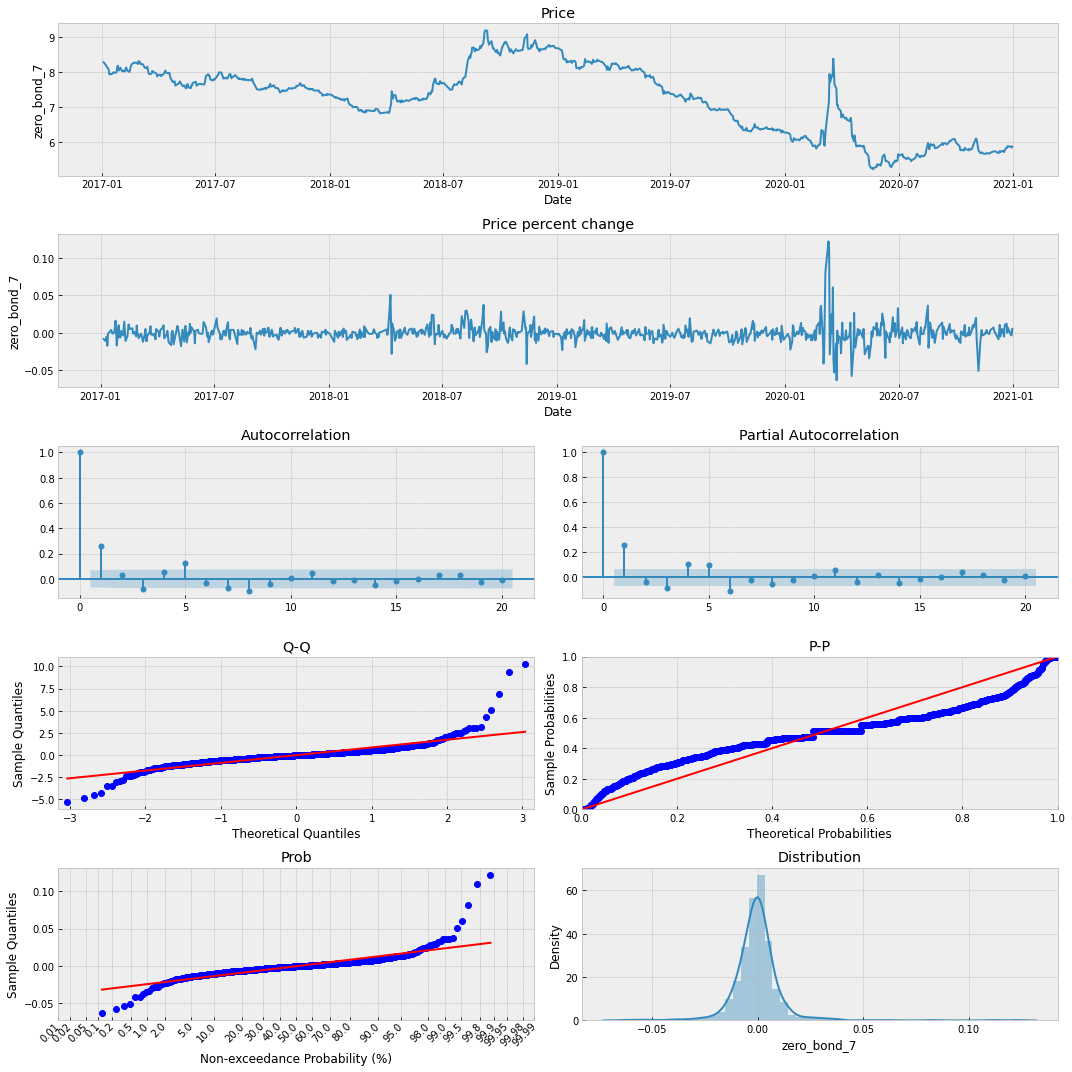

========== ZERO_BOND_10 ==========
mean: 7.43
std: 0.9
min: 5.59
max: 9.29
The Augmented Dickey-Fuller test, p-value: 0.5896513886825162, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 5.852023058023789e-21, series is stationary


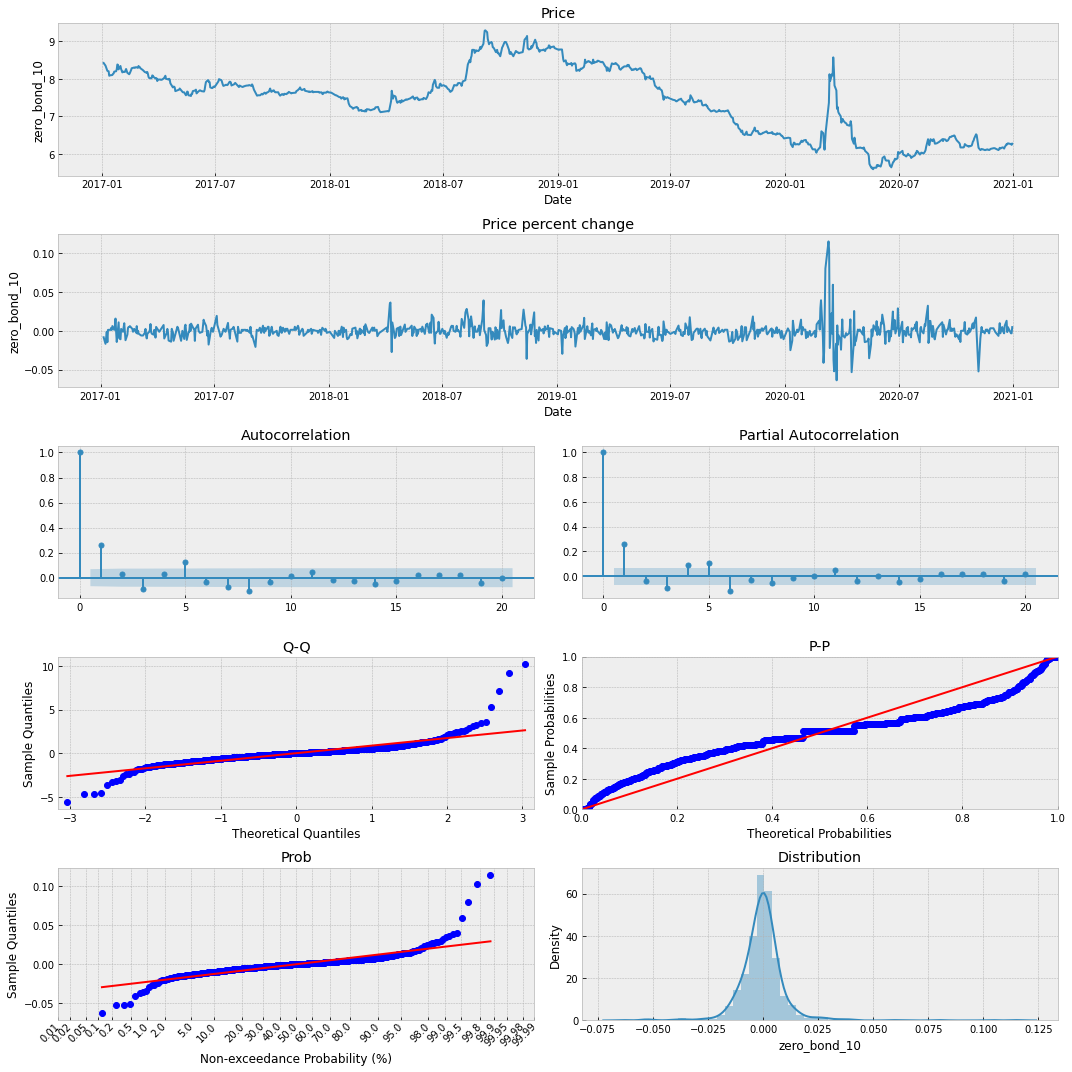

========== ZERO_BOND_15 ==========
mean: 7.66
std: 0.82
min: 5.97
max: 9.26
The Augmented Dickey-Fuller test, p-value: 0.5350408057580331, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 5.707973581159992e-21, series is stationary


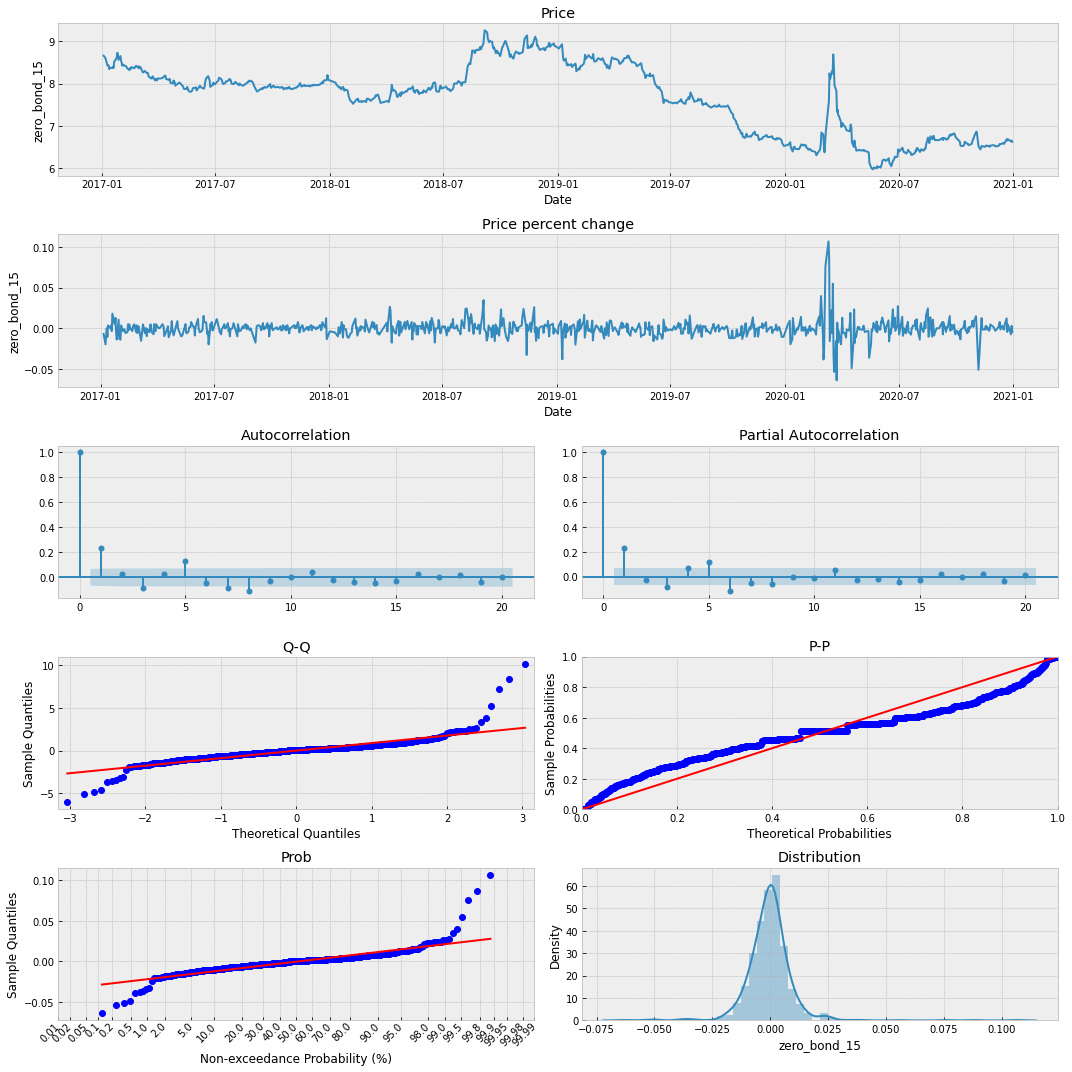

========== ZERO_BOND_20 ==========
mean: 7.83
std: 0.8
min: 6.17
max: 9.2
The Augmented Dickey-Fuller test, p-value: 0.6215021331653533, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 3.4569858115039115e-20, series is stationary


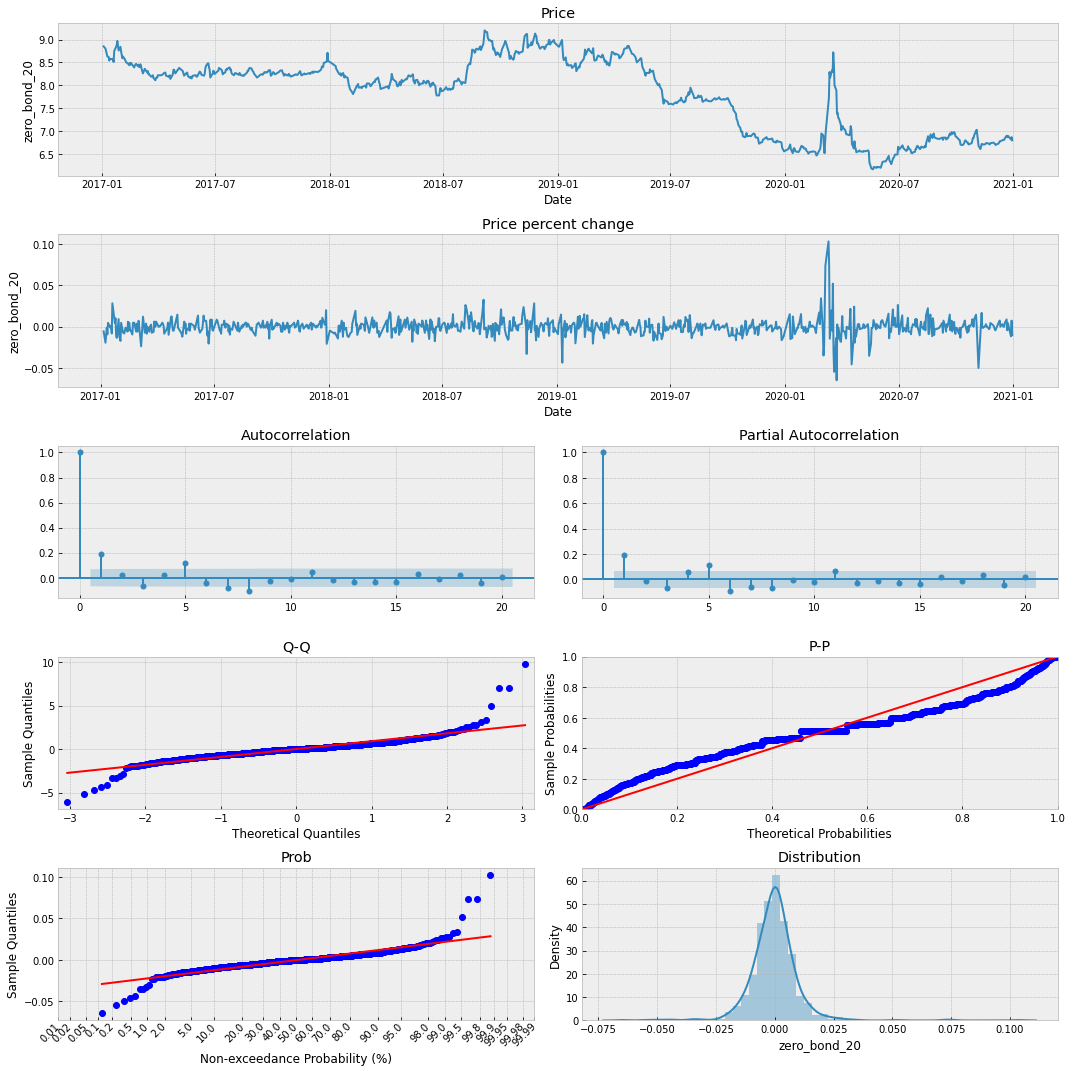

========== ZERO_BOND_30 ==========
mean: 8.07
std: 0.86
min: 6.37
max: 9.57
The Augmented Dickey-Fuller test, p-value: 0.5532863352269001, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 3.349753043015899e-20, series is stationary


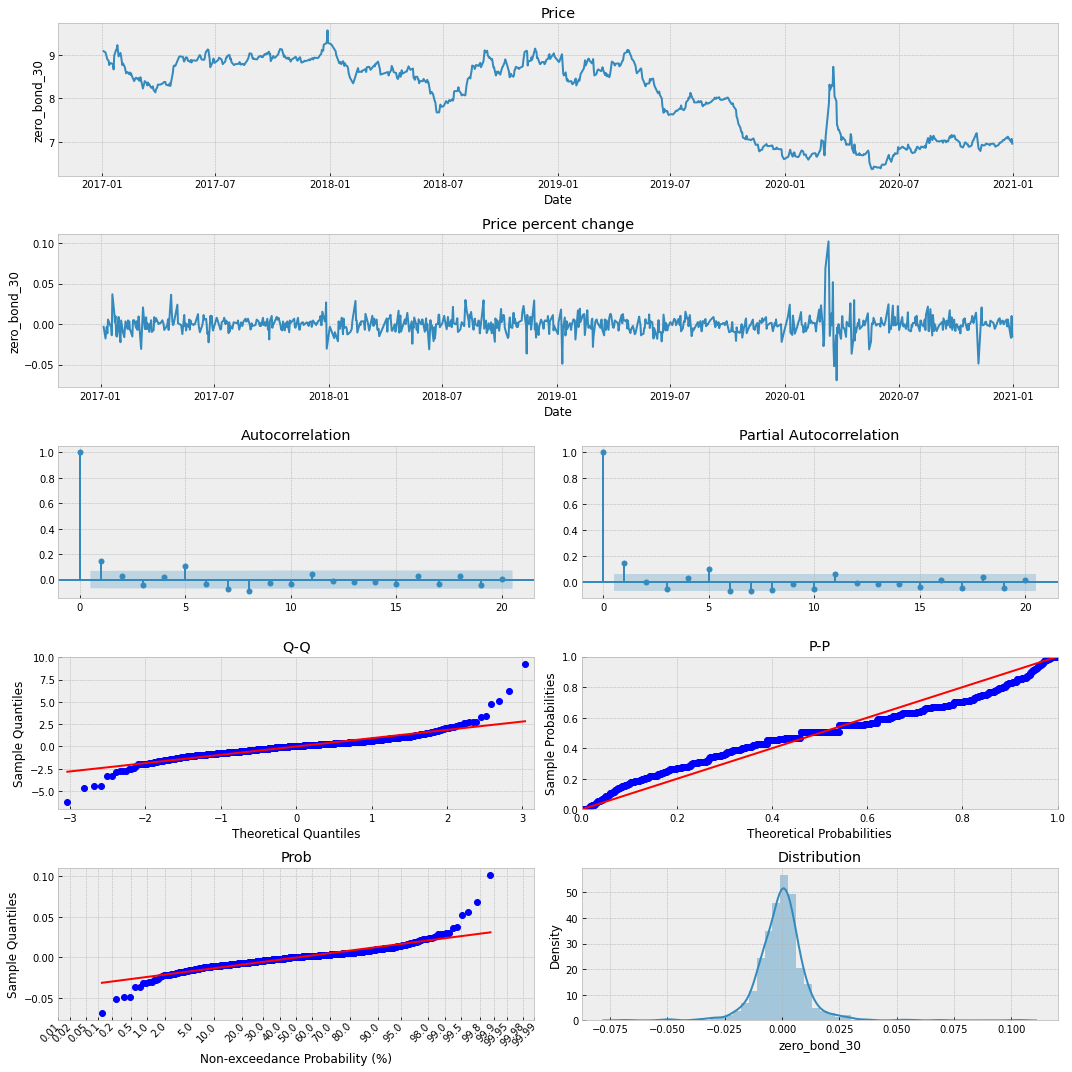

In [169]:
for col in risk_factors.columns:
    risk_factor_describe(risk_factors[col])

========== OIL ==========
mean: 58.3
std: 12.94
min: 19.33
max: 85.0
The Augmented Dickey-Fuller test, p-value: 0.522956536767029, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 5.04097100261234e-07, series is stationary


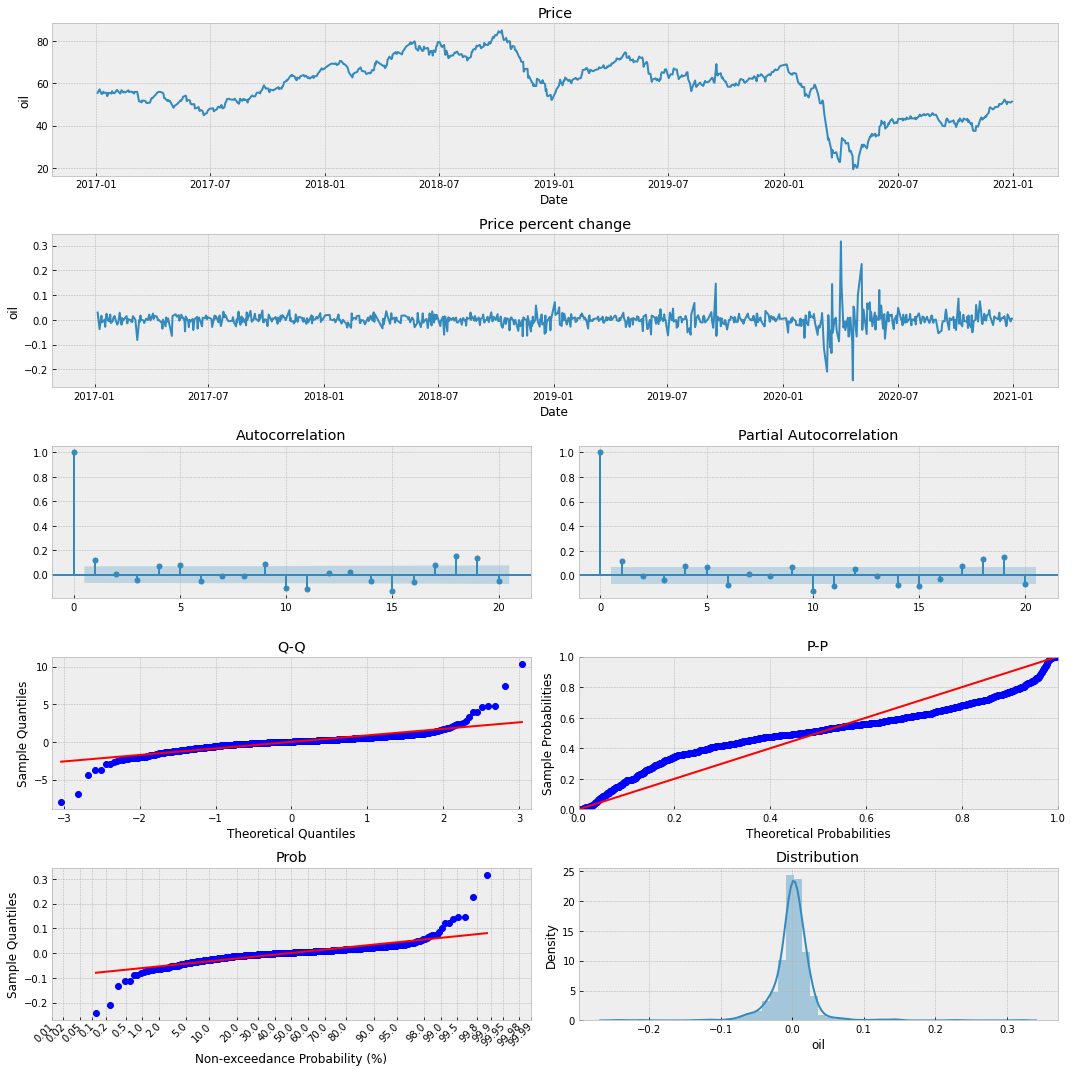

In [166]:
risk_factor_describe(risk_factors.oil)